<a href="https://colab.research.google.com/github/amFarrouk/OCR_prj/blob/main/simpleCNN_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
import zipfile
import numpy as np

In [2]:
!wget https://raw.githubusercontent.com/amFarrouk/OCR_prj/main/bdh.zip
!unzip -qq ./bdh.zip 
!rm ./bdh.zip

--2021-12-31 15:49:59--  https://raw.githubusercontent.com/amFarrouk/OCR_prj/main/bdh.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7536168 (7.2M) [application/zip]
Saving to: ‘bdh.zip’

bdh.zip             100%[===================>]   7.19M  44.4MB/s    in 0.2s    

2021-12-31 15:49:59 (44.4 MB/s) - ‘bdh.zip’ saved [7536168/7536168]



In [3]:
!wget https://www.dropbox.com/s/qpagi0h1089kr2f/images_df.csv

--2021-12-31 15:50:05--  https://www.dropbox.com/s/qpagi0h1089kr2f/images_df.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qpagi0h1089kr2f/images_df.csv [following]
--2021-12-31 15:50:05--  https://www.dropbox.com/s/raw/qpagi0h1089kr2f/images_df.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucacfd5d5c21265a489398a662c3.dl.dropboxusercontent.com/cd/0/inline/Bc5T4ZPJpKf5eVqcGb4efZUJ7RYhqKvj93hCBBqpwjbd2vJa11N6k533n6mphT55xRbmRJ1WvffOyd2RDEwukmaw18wF-UIRGzc7tJ8aKQqoBRcexhuc68uukTPGpquXkhLk5MXxjRTnfZNrtJt50jGQ/file# [following]
--2021-12-31 15:50:06--  https://ucacfd5d5c21265a489398a662c3.dl.dropboxusercontent.com/cd/0/inline/Bc5T4ZPJpKf5eVqcGb4efZUJ7RYhqKvj93hCBBqpwjbd2vJa11N6k533n6mphT55xRbmRJ1WvffOyd2RDEwukma

In [4]:
images_df=pd.read_csv("./images_df.csv",header=None,names=["img","label"])
images_df["label"]=images_df["label"].apply(lambda x : str(x))
images_df.head()

,img,label
0,ae07_005.bmp,18
1,ae07_011.bmp,17
2,ae07_014.bmp,20
3,ae07_015.bmp,18
4,ae07_022.bmp,12


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
all_x,all_y=images_df["img"],images_df["label"]

xtrain,xtest,ytrain,ytest=train_test_split(all_x,all_y,train_size=0.8,random_state=1,shuffle=True,stratify=all_y)

train_df=pd.DataFrame(xtrain,columns=["img"])
train_df["label"]=ytrain

print("train_data:")
train_df.head()

train_data:


,img,label
6638,di52_021.bmp,12
2475,bf52_031.bmp,8
5110,cj14_038.bmp,2
5837,de27_028.bmp,15
5810,de22_043.bmp,17


In [7]:
test_df=pd.DataFrame(xtest,columns=["img"])
test_df["label"]=ytest

print("test_data:")
test_df.head()

test_data:


,img,label
5920,de42_055.bmp,12
1782,aq41_004.bmp,17
5556,cq47_017.bmp,9
2898,bi72_006.bmp,10
1812,aq49_050.bmp,22


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
train_image_gen=ImageDataGenerator(rescale=1.0/255)
test_image_gen=ImageDataGenerator(rescale=1.0/255)

In [10]:
train_image_gen=train_image_gen.flow_from_dataframe(train_df,x_col="img",y_col="label",
                                            directory="./bdh",
                                            batch_size=32,
                                            target_size=(150,850),
                                            color_mode='grayscale',
                                            class_mode='sparse')

Found 6048 validated image filenames belonging to 22 classes.


In [11]:
test_image_gen=test_image_gen.flow_from_dataframe(test_df,x_col="img",y_col="label",
                                            directory="./bdh",
                                            batch_size=32,
                                            target_size=(150,850),
                                            color_mode='grayscale',
                                            class_mode='sparse')

Found 1512 validated image filenames belonging to 22 classes.


In [12]:
import tensorflow as tf

In [13]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 850x150 with 1 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 850, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Reshape((1,-1)),
    # Bidirectional layer of 32 neurons with LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # Only 22 output neuron.
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(22, activation='softmax')
])

In [14]:
loss=tf.keras.losses.sparse_categorical_crossentropy
optim=tf.keras.optimizers.Adam()
myCallBack=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

model.compile(optimizer=optim, loss=loss, metrics=['accuracy'])

_=tf.keras.utils.plot_model(
    model, to_file='./simpleCNN_RNN.png', show_shapes=True, show_layer_names=False,
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 848, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 424, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 422, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 211, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 209, 64)       36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 104, 64)      0

In [15]:
history=model.fit(train_image_gen,epochs=15,steps_per_epoch=189,validation_data=test_image_gen,callbacks=[myCallBack])

Epoch 1/15
189/189 [==============================] - 64s 235ms/step - loss: 1.5400 - accuracy: 0.5607 - val_loss: 0.4762 - val_accuracy: 0.8452
Epoch 2/15
189/189 [==============================] - 42s 220ms/step - loss: 0.2698 - accuracy: 0.9086 - val_loss: 0.2695 - val_accuracy: 0.9193
Epoch 3/15
189/189 [==============================] - 42s 221ms/step - loss: 0.0900 - accuracy: 0.9760 - val_loss: 0.2214 - val_accuracy: 0.9378
Epoch 4/15
189/189 [==============================] - 42s 220ms/step - loss: 0.0239 - accuracy: 0.9950 - val_loss: 0.2078 - val_accuracy: 0.9497
Epoch 5/15
189/189 [==============================] - 42s 221ms/step - loss: 0.0087 - accuracy: 0.9992 - val_loss: 0.1972 - val_accuracy: 0.9530
Epoch 6/15
189/189 [==============================] - 42s 222ms/step - loss: 0.0027 - accuracy: 0.9998 - val_loss: 0.1969 - val_accuracy: 0.9537
Epoch 7/15
189/189 [==============================] - 42s 222ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.1977 - val_ac

In [16]:
#-----------------------------------------------------------------------
# Retrieve a list of list results on training and test data of 1st model
# sets for each training epoch
#-----------------------------------------------------------------------
acc_hist=history.history['accuracy']
val_acc_hist=history.history['val_accuracy']
loss_hist=history.history['loss']
val_loss_hist=history.history['val_loss']

epochs=range(len(acc_hist)) # Get number of epochs

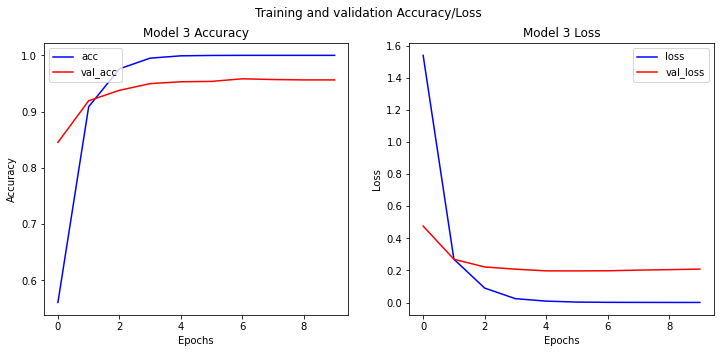

In [30]:
#-----------------------------------------------------------------------
# Plot training and validation accuracy and loss per epoch for 3rd model
#-----------------------------------------------------------------------
fig, (axs1, axs2) = plt.subplots(1, 2,figsize=(12,5),sharey=False)
fig.suptitle('Training and validation Accuracy/Loss')

axs1.set_title('Model 3 Accuracy')
axs1.set(xlabel="Epochs",ylabel="Accuracy")
axs1.plot(epochs, acc_hist,'b',label="acc")
axs1.plot(epochs, val_acc_hist,'r',label="val_acc")
axs1.legend(loc="upper left")

axs2.set_title('Model 3 Loss')
axs2.set(xlabel="Epochs",ylabel="Loss")
axs2.plot(epochs, loss_hist,'b',label="loss")
axs2.plot(epochs, val_loss_hist,'r',label="val_loss")
axs2.legend(loc="upper right")

plt.savefig("model3accloss.png")
plt.show()

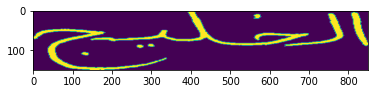

img_batch shape (1, 150, 850, 1)


1

In [34]:
#test place

"""
5920	de42_055.bmp	12
1782	aq41_004.bmp	17
5556	cq47_017.bmp	9
2898	bi72_006.bmp	10
1812	aq49_050.bmp	22
"""

#img_path = "chimakh.bmp"

img_path="./bdh/bi72_006.bmp"
img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
img= cv2.resize(img,(850,150))
#img=img/255.0

plt.imshow(img)
plt.show()

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

print("img_batch shape",img_batch.shape)

prediction = model.predict(img_batch)
np.argmax(prediction,axis=1)[0]

In [33]:
train_image_gen.class_indices

{'1': 0,
 '10': 1,
 '11': 2,
 '12': 3,
 '13': 4,
 '14': 5,
 '15': 6,
 '16': 7,
 '17': 8,
 '18': 9,
 '19': 10,
 '2': 11,
 '20': 12,
 '21': 13,
 '22': 14,
 '3': 15,
 '4': 16,
 '5': 17,
 '6': 18,
 '7': 19,
 '8': 20,
 '9': 21}